Analysis by Vallian Sayoga

Dataset by BRI (The details of sensitive information have been omitted to protect privacy)

This is an analysis on BRI customers data that have or not churned. The analysis is done to create a predictive model on customers churning.

Here, I demonstrated skills in:
1. Working with huge dataset
1. Data cleaning
1. Analysis on imbalanced dataset
1. Features selection using algorithmic method
1. Models creation and evaluation

Based on this analysis, **Random Forest** is the best model for this dataset with AUC score of 0.733 on validation data.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn

sns.set_theme()

# Check dataset basic features

In [3]:
df = pd.read_csv("findata_challenge_train.csv")

In [4]:
df.y.value_counts()

0    83008
1    16992
Name: y, dtype: int64

In [5]:
df.shape

(100000, 126)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 126 entries, x0 to y
dtypes: float64(120), int64(1), object(5)
memory usage: 96.1+ MB


In [7]:
con_var = [col for col in df.columns if df[col].dtype == np.float64]
cat_var = [col for col in df.columns if df[col].dtype == object]

# Imputing continuous variables with KNN Imputer
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)
df[con_var] = imputer.fit_transform(df[con_var])
    
# Imputing categorical variables with their mode
for col in cat_var:
    df[col] = df[col].replace(np.nan, df[col].mode()[0])

In [12]:
NA = df.isna().sum()
NA[NA != 0]

Series([], dtype: int64)

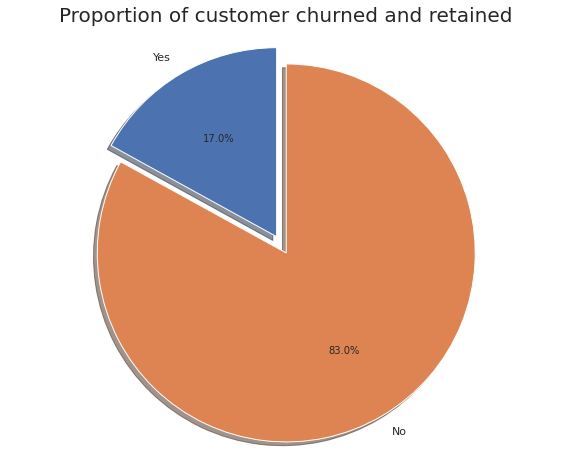

In [13]:
# Proportion of churning customers
labels = 'Yes', 'No'
sizes = [df.y[df['y']==1].count(), df.y[df['y']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and retained", size = 20)
plt.show()

This is an imbalanced dataset with 17% churned. We have to do some balancing on the data set.

**Boxplots of continuous variables**

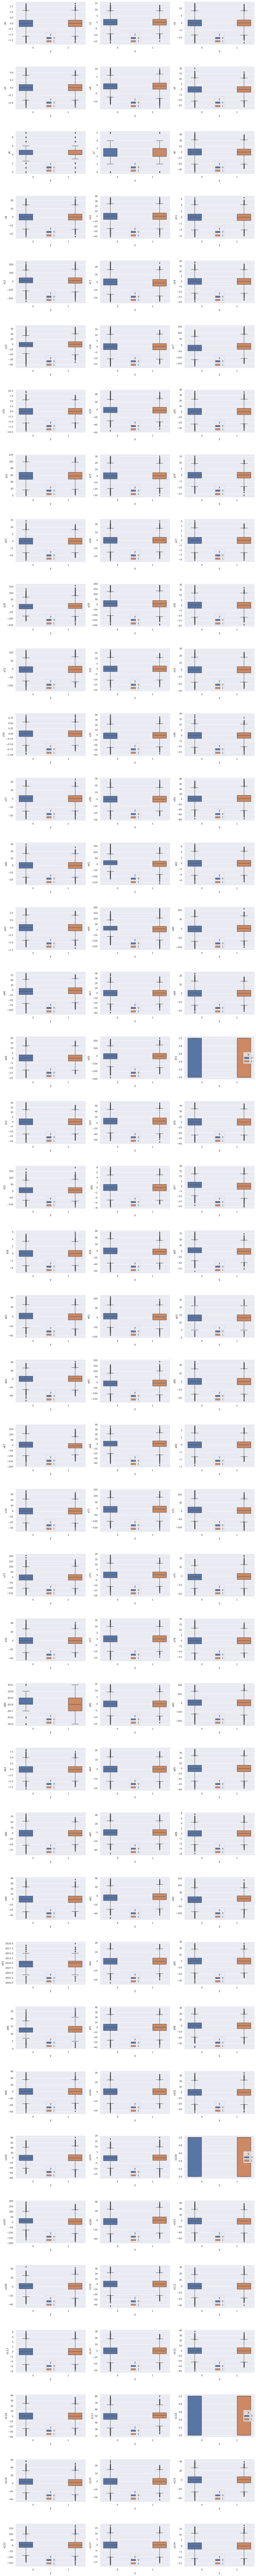

In [14]:
fig, axs = plt.subplots(nrows=40, ncols=3, figsize=(20,220))
plt.subplots_adjust(hspace=.5)

for con, ax in zip(con_var, axs.ravel()):
    sns.boxplot(y=con, x='y', data=df, hue='y', ax=ax)

Boxplot menunjukan bahwa dataset training banyak mengandung outlier sehingga cocok di-scale dengan RobustScaler

**Column charts of categorical variables**

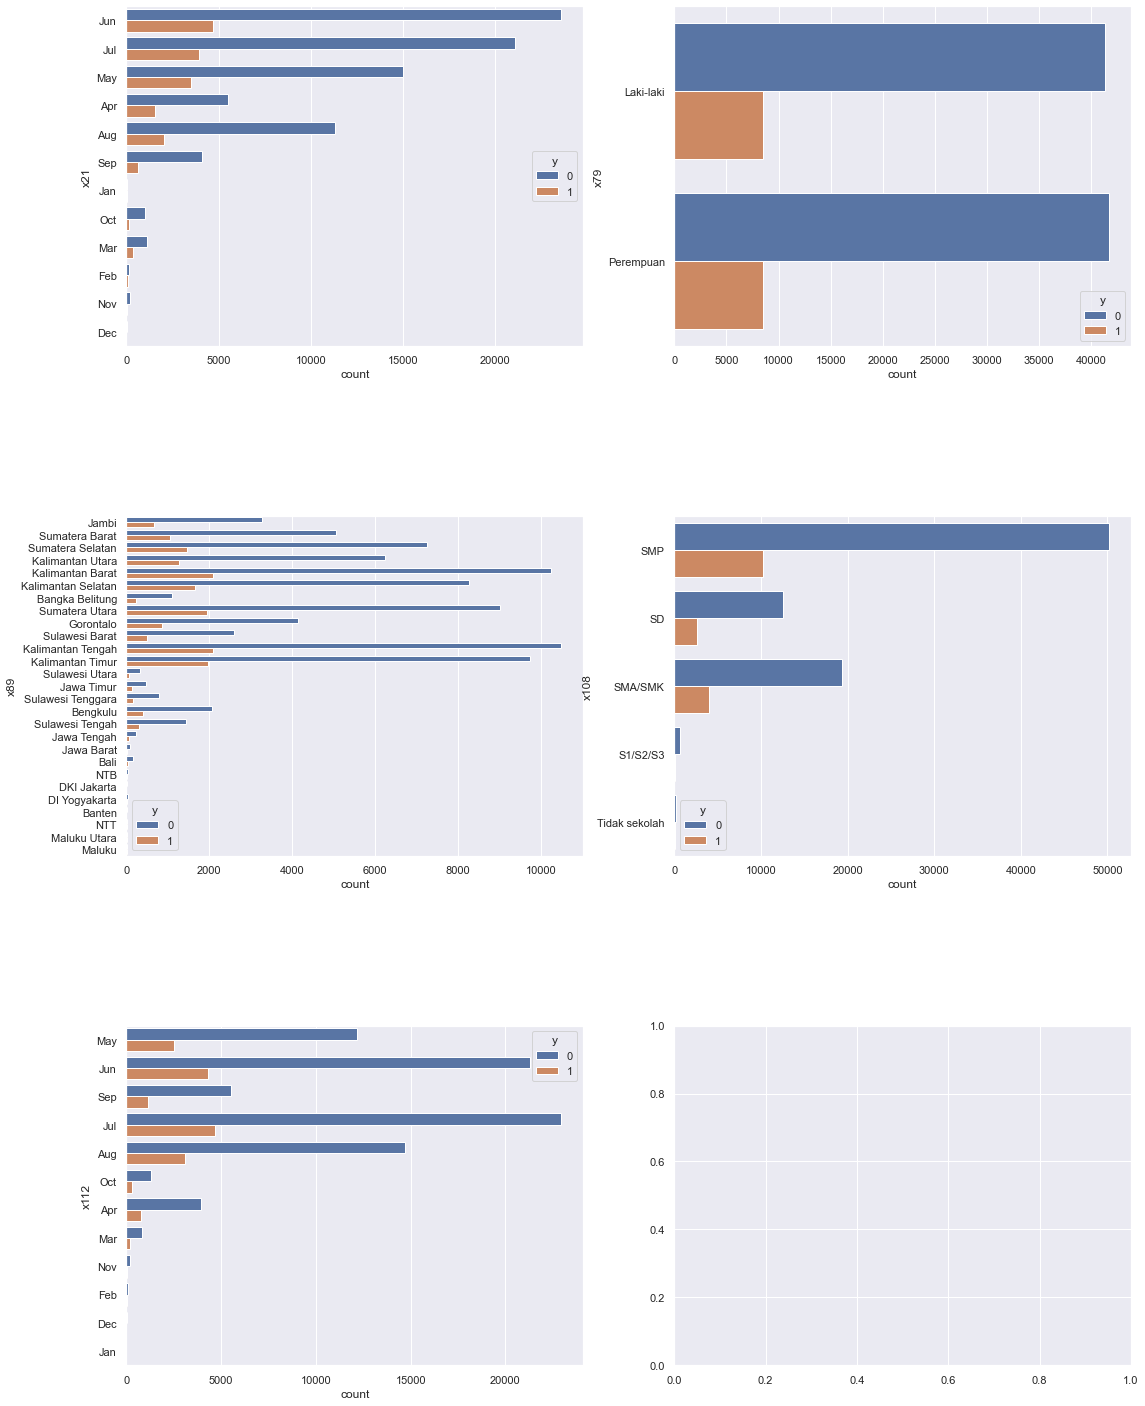

In [12]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(18,25))
plt.subplots_adjust(hspace=.5)

for con, ax in zip(cat_var, axs.ravel()):
    sns.countplot(y=con, data=df, hue='y', ax=ax)

The details on column names have been deleted so these are the only conclusion I can get without any contexts at all.

1. Churning mostly happen in June (first chart) dan July (fifth chart)
    * Why those months have the highest churning rate?
1. There is no difference in gender
1. Provinces that experience highest churning rate: Kalimantan (East, Central, West) and North Sumatera
    * BRI must create a policy to retain customers in those provinces
1. Customers with midle school education level (SMP) have the highest churning rate
    * A further investigation must be done to find the correlation between education levels and churning rate

In [16]:
# Support functions
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

# Fit models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

# Scoring functions
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

In [17]:
# Creating CV object
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=2, random_state=2022)

# Data pre-processing

In [35]:
X = df.drop('y', axis=1)
y = df['y']

In [36]:
# Converting all of the categorical into numerical
for column in X.columns:
    if X[column].dtype == object:
        X[column] = LabelEncoder().fit_transform(X[column])

# Scaling data dengan RobustScaler karena banyak outlier di boxplot
from sklearn.preprocessing import RobustScaler
X = RobustScaler().fit_transform(X)

# Feature selection using ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X, y)

model = SelectFromModel(clf, prefit=True)
X = model.transform(X)

# Features mask
mask = model.get_support()

In [39]:
# Splitting to train dan validation
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, random_state=2022, test_size=0.1)

# SMOTE balancing data set
from imblearn.over_sampling import SMOTE
oversample = SMOTE(random_state=2022)
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [40]:
y_train.value_counts()

0    74682
1    74682
Name: y, dtype: int64

In [41]:
y_val.value_counts()

0    8326
1    1674
Name: y, dtype: int64

In [23]:
# Function to get auc scores
def get_auc_scores(y_actual, method, method2):
    auc_score = roc_auc_score(y_actual, method); 
    fpr_df, tpr_df, _ = roc_curve(y_actual, method2); 
    return (auc_score, fpr_df, tpr_df)

# Model testing & cross_val_score

Churning prediction is binary classification. Suitable models for this are
1. Logistic regression
1. KNN classifier
1. Naive bayes
1. Stochastic gradient
1. Ada boost classifier
1. Random forest
1. Extreme gradient boost

**Ada boost Classifier**

In [42]:
from sklearn.ensemble import AdaBoostClassifier
Ada = AdaBoostClassifier()
Ada.fit(X_train, y_train)
AdaCross = cross_val_score(Ada, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
AdaCross.mean()

0.7850181657725201

**Logistic Regression**

In [43]:
log = LogisticRegression(random_state=2022, max_iter=250, n_jobs=-1)
log.fit(X_train, y_train)
logCross = cross_val_score(log,X_train, y_train,cv=cv,scoring='roc_auc', n_jobs=-1)
logCross.mean()

0.6494227745269288

**Random Forest**

In [44]:
RF = RandomForestClassifier(oob_score=True, random_state=2022, max_features = 8)
RF.fit(X_train, y_train)
RFCross = cross_val_score(RF, X_train, y_train,cv=cv,scoring='roc_auc', n_jobs=-1)
RFCross.mean()

0.9824562121506513

**Extreme Gradient Boost**

In [45]:
XGB = XGBClassifier(use_label_encoder=False, base_score=0.5, booster='gbtree', objective='binary:logistic')
XGB.fit(X_train, y_train)
XGBCross = cross_val_score(XGB,X_train, y_train,cv=cv,scoring='roc_auc', n_jobs=-1)
XGBCross.mean()

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0.9016384857038935

**Naive Bayes**

In [46]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnbCross = cross_val_score(gnb, X_train, y_train,cv=cv,scoring='roc_auc', n_jobs=-1)
gnbCross.mean()

0.6805028525543811

**Stochastic Gradient**

In [47]:
from sklearn.linear_model import SGDClassifier
SGD = SGDClassifier(loss="log", penalty="l2", max_iter=100)
SGD.fit(X_train, y_train)
SGDCross = cross_val_score(SGD,X_train, y_train,cv=cv,scoring='roc_auc', n_jobs=-1)
SGDCross.mean()

0.6386626967220891

**KNN Classifier**

In [48]:
# weights = distance
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3, weights='distance', n_jobs=-1)
neigh.fit(X_train, y_train)
neighCross = cross_val_score(neigh,X_train, y_train,cv=cv,scoring='roc_auc')
neighCross.mean()

0.9457024073606526

In [49]:
# weights = default
neigh2 = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
neigh2.fit(X_train, y_train)
neigh2Cross = cross_val_score(neigh2,X_train, y_train,cv=cv,scoring='roc_auc')
neigh2Cross.mean()

0.9405682978741898

# Classification reports

In [50]:
# Logistic
print(classification_report(y_train, log.predict(X_train)))
print(classification_report(y_val, log.predict(X_val)))

              precision    recall  f1-score   support

           0       0.60      0.64      0.62     74682
           1       0.62      0.57      0.59     74682

    accuracy                           0.61    149364
   macro avg       0.61      0.61      0.61    149364
weighted avg       0.61      0.61      0.61    149364

              precision    recall  f1-score   support

           0       0.88      0.65      0.75      8326
           1       0.24      0.56      0.34      1674

    accuracy                           0.63     10000
   macro avg       0.56      0.60      0.54     10000
weighted avg       0.77      0.63      0.68     10000



In [51]:
# Random forest
print(classification_report(y_train, RF.predict(X_train)))
print(classification_report(y_val, RF.predict(X_val)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     74682
           1       1.00      1.00      1.00     74682

    accuracy                           1.00    149364
   macro avg       1.00      1.00      1.00    149364
weighted avg       1.00      1.00      1.00    149364

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      8326
           1       0.82      0.49      0.61      1674

    accuracy                           0.90     10000
   macro avg       0.86      0.73      0.78     10000
weighted avg       0.89      0.90      0.89     10000



In [52]:
# XGBOOST
print(classification_report(y_train, XGB.predict(X_train)))
print(classification_report(y_val, XGB.predict(X_val)))

              precision    recall  f1-score   support

           0       0.78      0.95      0.86     74682
           1       0.94      0.73      0.82     74682

    accuracy                           0.84    149364
   macro avg       0.86      0.84      0.84    149364
weighted avg       0.86      0.84      0.84    149364

              precision    recall  f1-score   support

           0       0.88      0.95      0.92      8326
           1       0.62      0.37      0.46      1674

    accuracy                           0.86     10000
   macro avg       0.75      0.66      0.69     10000
weighted avg       0.84      0.86      0.84     10000



In [53]:
# Naive bayes
print(classification_report(y_train, gnb.predict(X_train)))
print(classification_report(y_val, gnb.predict(X_val)))

              precision    recall  f1-score   support

           0       0.63      0.64      0.63     74682
           1       0.63      0.63      0.63     74682

    accuracy                           0.63    149364
   macro avg       0.63      0.63      0.63    149364
weighted avg       0.63      0.63      0.63    149364

              precision    recall  f1-score   support

           0       0.89      0.65      0.75      8326
           1       0.26      0.61      0.36      1674

    accuracy                           0.64     10000
   macro avg       0.58      0.63      0.56     10000
weighted avg       0.79      0.64      0.68     10000



In [54]:
# Stochastic Gradient
print(classification_report(y_train, SGD.predict(X_train)))
print(classification_report(y_val, SGD.predict(X_val)))

              precision    recall  f1-score   support

           0       0.59      0.72      0.65     74682
           1       0.64      0.49      0.55     74682

    accuracy                           0.60    149364
   macro avg       0.61      0.60      0.60    149364
weighted avg       0.61      0.60      0.60    149364

              precision    recall  f1-score   support

           0       0.87      0.73      0.80      8326
           1       0.26      0.48      0.34      1674

    accuracy                           0.69     10000
   macro avg       0.57      0.60      0.57     10000
weighted avg       0.77      0.69      0.72     10000



In [55]:
# KNN
print(classification_report(y_train, neigh.predict(X_train)))
print(classification_report(y_val, neigh.predict(X_val)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     74682
           1       1.00      1.00      1.00     74682

    accuracy                           1.00    149364
   macro avg       1.00      1.00      1.00    149364
weighted avg       1.00      1.00      1.00    149364

              precision    recall  f1-score   support

           0       0.91      0.76      0.83      8326
           1       0.34      0.62      0.44      1674

    accuracy                           0.74     10000
   macro avg       0.63      0.69      0.64     10000
weighted avg       0.81      0.74      0.76     10000



In [56]:
# KNN-2
print(classification_report(y_train, neigh2.predict(X_train)))
print(classification_report(y_val, neigh2.predict(X_val)))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93     74682
           1       0.89      1.00      0.94     74682

    accuracy                           0.94    149364
   macro avg       0.94      0.94      0.94    149364
weighted avg       0.94      0.94      0.94    149364

              precision    recall  f1-score   support

           0       0.91      0.76      0.83      8326
           1       0.34      0.62      0.44      1674

    accuracy                           0.74     10000
   macro avg       0.63      0.69      0.64     10000
weighted avg       0.81      0.74      0.76     10000



In [57]:
# Ada
print(classification_report(y_train, Ada.predict(X_train)))
print(classification_report(y_val, Ada.predict(X_val)))

              precision    recall  f1-score   support

           0       0.71      0.75      0.73     74682
           1       0.74      0.69      0.71     74682

    accuracy                           0.72    149364
   macro avg       0.72      0.72      0.72    149364
weighted avg       0.72      0.72      0.72    149364

              precision    recall  f1-score   support

           0       0.89      0.77      0.82      8326
           1       0.31      0.51      0.38      1674

    accuracy                           0.73     10000
   macro avg       0.60      0.64      0.60     10000
weighted avg       0.79      0.73      0.75     10000



# AUC

In [58]:
# Capture ROC AUC for validation data
auc_log_val, fpr_log_val, tpr_log_val = get_auc_scores(y_val, log.predict(X_val),log.predict_proba(X_val)[:,1])
auc_RF_val, fpr_RF_val, tpr_RF_val = get_auc_scores(y_val, RF.predict(X_val),RF.predict_proba(X_val)[:,1])
auc_XGB_val, fpr_XGB_val, tpr_XGB_val = get_auc_scores(y_val, XGB.predict(X_val),XGB.predict_proba(X_val)[:,1])
auc_gnb_val, fpr_gnb_val, tpr_gnb_val = get_auc_scores(y_val, gnb.predict(X_val),gnb.predict_proba(X_val)[:,1])
auc_SGD_val, fpr_SGD_val, tpr_SGD_val = get_auc_scores(y_val, SGD.predict(X_val),SGD.predict_proba(X_val)[:,1])
auc_neigh_val, fpr_neigh_val, tpr_neigh_val = get_auc_scores(y_val, neigh.predict(X_val),neigh.predict_proba(X_val)[:,1])
auc_neigh2_val, fpr_neigh2_val, tpr_neigh2_val = get_auc_scores(y_val, neigh2.predict(X_val),neigh2.predict_proba(X_val)[:,1])
auc_Ada_val, fpr_Ada_val, tpr_Ada_val = get_auc_scores(y_val, Ada.predict(X_val),Ada.predict_proba(X_val)[:,1])

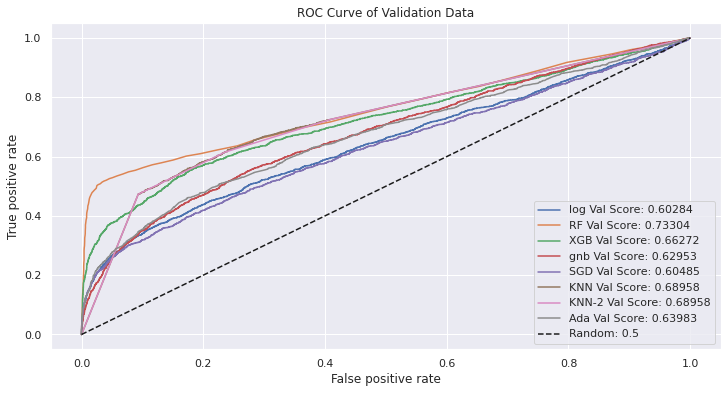

In [59]:
plt.figure(figsize = (12,6), linewidth= 1)
plt.plot(fpr_log_val, tpr_log_val, label = 'log Val Score: ' + str(round(auc_log_val, 5)))
plt.plot(fpr_RF_val, tpr_RF_val, label = 'RF Val Score: ' + str(round(auc_RF_val, 5)))
plt.plot(fpr_XGB_val, tpr_XGB_val, label = 'XGB Val Score: ' + str(round(auc_XGB_val, 5)))
plt.plot(fpr_gnb_val, tpr_gnb_val, label = 'gnb Val Score: ' + str(round(auc_gnb_val, 5)))
plt.plot(fpr_SGD_val, tpr_SGD_val, label = 'SGD Val Score: ' + str(round(auc_SGD_val, 5)))
plt.plot(fpr_neigh_val, tpr_neigh_val, label = 'KNN Val Score: ' + str(round(auc_neigh_val, 5)))
plt.plot(fpr_neigh2_val, tpr_neigh2_val, label = 'KNN-2 Val Score: ' + str(round(auc_neigh2_val, 5)))
plt.plot(fpr_Ada_val, tpr_Ada_val, label = 'Ada Val Score: ' + str(round(auc_Ada_val, 5)))

plt.plot([0,1], [0,1], 'k--', label = 'Random: 0.5')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve of Validation Data')
plt.legend(loc='best')
plt.show()

# Predicting test data

In [72]:
X_test = pd.read_csv("findata_challenge_test.csv")
X_test.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,...,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100,x101,x102,x103,x104,x105,x106,x107,x108,x109,x110,x111,x112,x113,x114,x115,x116,x117,x118,x119,x120,x121,x122,x123,x124
0,0.403735,-1.966104,-1.322339,0.084642,2.481997,-1.719155,5.0,2.0,-11.546670,-7.073770,19.190305,-0.573680,40.638818,4.959509,-5.846384,-2.030356,-4.044550,-33.483013,1.646322,-14.783878,-10.196623,Jul,93.0,6.703102,-2.997792,5.043638,3.225896,-0.409038,19.651910,41.516470,1.312061,44.933636,-7.028450,9.317049,-0.076843,0.044943,4.810161,6.234618,-3.325209,16.140605,...,-3.092107,-17.178294,-2.734587,-0.915121,Sumatera Utara,3.854819,11.314554,9.341044,2011.0,11.651429,10.597152,14.0,-15.343557,-1.521859,4.299955,2.162244,-8.799300,-27.642849,-4.374817,0.0,25.630266,5.707664,18.401418,SMP,-7.976135,-5.225101,7.936675,Aug,-2.433553,-6.735313,3.580278,-7.765934,59.0,1.0,-9.897690,5.694125,-6.734618,17.052251,3.601040,2.873498
1,0.032128,6.516294,-0.939752,0.026937,-0.992999,5.995462,4.0,3.0,-5.634876,1.937998,-2.504143,-2.373585,33.050618,-2.020895,-1.194576,-9.165506,5.361384,26.920458,-0.219553,-6.425862,-2.120709,Jul,57.0,-6.528313,-1.127927,3.175399,-2.953814,1.063006,-13.530803,-4.395194,8.704515,24.533511,1.530274,-0.542090,0.127249,-1.752173,-5.743168,-2.271264,1.732550,9.891922,...,-3.084426,-17.914152,-12.178884,-1.687117,Gorontalo,1.422343,9.427296,52.037373,2012.0,3.329784,1.913478,13.0,-11.264199,6.381821,0.352352,-8.723329,-11.187814,13.474251,0.252021,1.0,42.942199,10.207805,-5.169689,SMP,-2.438489,6.711742,-13.230700,Sep,4.018552,-2.819736,5.783655,15.667015,47.0,1.0,7.781887,9.752716,5.918369,15.922908,5.460557,10.475816
2,-0.280345,0.930291,-1.028828,-0.050924,-3.164733,6.885108,3.0,2.0,1.609005,-1.812488,10.285959,-0.598467,-69.953829,6.498108,-5.922763,9.434490,3.227001,-41.503477,-0.763864,25.406922,-2.914999,Jun,57.0,-10.361185,3.441997,-0.936675,7.369928,0.079292,4.280407,43.430442,-1.008000,-7.476300,0.649751,-1.416041,0.037022,-0.216140,8.343297,-1.693852,6.409895,-20.987141,...,5.532291,-3.155798,3.708371,2.210236,Sumatera Utara,-6.061117,9.183305,-25.182331,2011.0,3.313167,1.021627,12.0,-6.884527,10.006112,-22.058081,3.691350,-3.613650,-13.838661,-2.128526,1.0,-1.026669,-10.455741,10.843699,SMP,4.195810,-4.480700,16.766250,Aug,-1.824187,4.535578,-0.389116,8.523648,55.0,0.0,6.815214,-3.325532,4.123546,-19.656038,8.380318,-1.203315
3,-0.313420,-0.568857,-1.576051,-0.003607,5.539969,-1.594770,4.0,3.0,-11.517734,-5.364282,-15.394059,3.414467,40.895826,12.038212,0.765863,-12.081526,4.405757,-14.767465,-2.838872,6.822953,-2.471574,Sep,38.0,7.975975,-2.966182,-4.289650,1.479258,0.710806,-118.105541,-13.103402,0.762168,26.038436,0.730760,0.855741,0.108688,3.462986,-12.322187,-0.737025,-19.310404,-9.520847,...,-7.077689,24.530414,-11.074852,2.167684,Jambi,-8.276723,-3.031502,-50.888465,2011.0,2.606337,6.562047,8.0,11.495752,8.227573,-28.268630,2.491183,-11.167360,3.603536,3.969886,1.0,85.185923,-11.169927,32.471671,SMP,-0.059301,-9.034379,-0.457020,Jun,1.565952,-2.429470,3.930974,-13.912115,41.0,0.0,3.158137,-7.088875,-3.035983,34.277048,-3.169203,1.417681
4,0.108825,-4.815631,5.491084,-0.123928,-1.932024,4.014821,5.0,3.0,-3.117576,2.004889,-10.952905,1.235227,37.705221,5.525227,1.054455,-0.723274,0.729063,32.975593,0.271822,-2.000956,9.826929,Mar,61.0,0.058984,6.329002,2.580989,11.872609,-1.034911,-26.765844,-45.363907,-4.239141,1.656484,1.734858,12.566598,0.009538,13.566662,3.288173,1.847609,-0.748936,20.445398,...,7.532882,35.755711,-8.818639,0.014404,Kalimantan Timur,1.745095,-18.765315,9.421105,2008.0,3.171193,2.904219,12.0,4.148268,-16.542376,29.041724,-0.252975,4.522465,1.902776,2.115363,1.0,-2.742862,15.505272,-27.519575,SMP,-3.799728,5.281775,4.619400,May,2.685108,4.233022,-4.056091,-14.432712,52.0,0.0,-3.867657,-13.308519,1.008302,41.449381,-0.804560,-0.649453


In [73]:
con_var = [col for col in X_test.columns if X_test[col].dtype == np.float64]
cat_var = [col for col in X_test.columns if X_test[col].dtype == object]

# Imputing continuous variables with KNN imputer
imputer = KNNImputer(n_neighbors=2)
X_test[con_var] = imputer.fit_transform(X_test[con_var])

# Imputing categorical variables with their mode
for col in cat_var:
    X_test[col] = X_test[col].replace(np.nan, X_test[col].mode()[0])

# Masking selected features
X_test = X_test.loc[:, mask]

# Converting all of the categorical into numerical    
for column in X_test.columns:
    if X_test[column].dtype == object:
        X_test[column] = LabelEncoder().fit_transform(X_test[column])

In [74]:
# Hanya men-transform test data        
X_test = RobustScaler().fit_transform(X_test)

   Id  Prediction
0   0           1
1   1           0
2   2           0
3   3           0
4   4           0


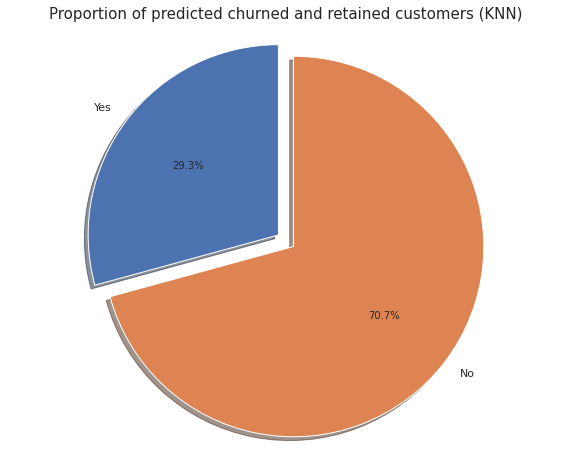

In [75]:
# KNN
Prediction = neigh.predict(X_test)
Id = list(range(len(Prediction)))
submission = pd.DataFrame({
    "Id":Id,
    "Prediction":Prediction
})
print(submission.head())

# Proportion of churning customers
labels = 'Yes', 'No'
sizes = [submission.Prediction[submission['Prediction']==1].count(), submission.Prediction[submission['Prediction']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of predicted churned and retained customers (KNN)", size = 15)
plt.show()

   Id  Prediction
0   0           1
1   1           0
2   2           0
3   3           0
4   4           0


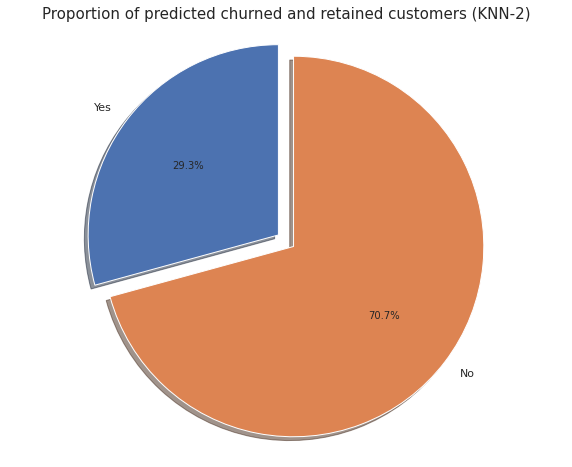

In [76]:
# KNN-2
Prediction = neigh2.predict(X_test)
Id = list(range(len(Prediction)))
submission = pd.DataFrame({
    "Id":Id,
    "Prediction":Prediction
})
print(submission.head())

# Proportion of churning customers
labels = 'Yes', 'No'
sizes = [submission.Prediction[submission['Prediction']==1].count(), submission.Prediction[submission['Prediction']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of predicted churned and retained customers (KNN-2)", size = 15)
plt.show()

   Id  Prediction
0   0           0
1   1           1
2   2           0
3   3           0
4   4           1


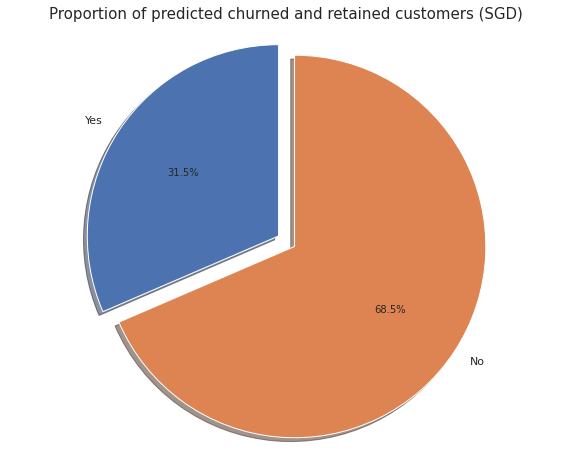

In [77]:
# SGD
Prediction = SGD.predict(X_test)
Id = list(range(len(Prediction)))
submission = pd.DataFrame({
    "Id":Id,
    "Prediction":Prediction
})
print(submission.head())

# Proportion of churning customers
labels = 'Yes', 'No'
sizes = [submission.Prediction[submission['Prediction']==1].count(), submission.Prediction[submission['Prediction']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of predicted churned and retained customers (SGD)", size = 15)
plt.show()

   Id  Prediction
0   0           0
1   1           0
2   2           0
3   3           0
4   4           0


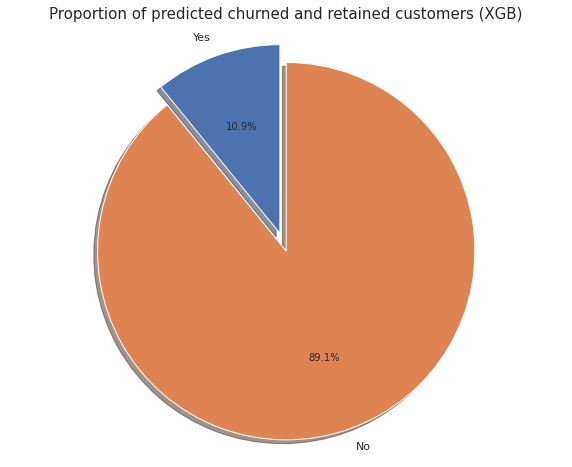

In [78]:
# XGB
Prediction = XGB.predict(X_test)
Id = list(range(len(Prediction)))
submission = pd.DataFrame({
    "Id":Id,
    "Prediction":Prediction
})
print(submission.head())

# Proportion of churning customers
labels = 'Yes', 'No'
sizes = [submission.Prediction[submission['Prediction']==1].count(), submission.Prediction[submission['Prediction']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of predicted churned and retained customers (XGB)", size = 15)
plt.show()

   Id  Prediction
0   0           0
1   1           0
2   2           0
3   3           0
4   4           0


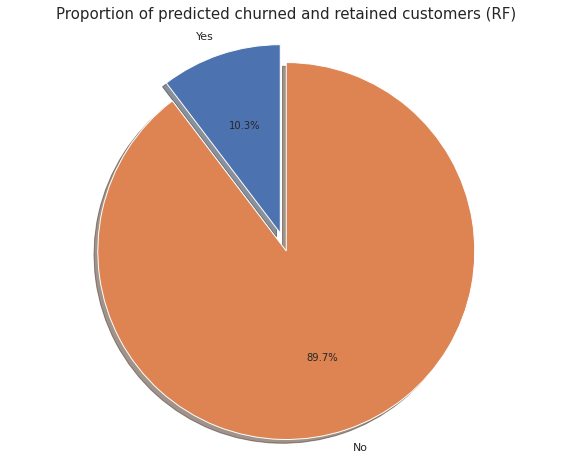

In [79]:
# RF
Prediction = RF.predict(X_test)
Id = list(range(len(Prediction)))
submission = pd.DataFrame({
    "Id":Id,
    "Prediction":Prediction
})
print(submission.head())

# Proportion of churning customers
labels = 'Yes', 'No'
sizes = [submission.Prediction[submission['Prediction']==1].count(), submission.Prediction[submission['Prediction']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of predicted churned and retained customers (RF)", size = 15)
plt.show()

   Id  Prediction
0   0           1
1   1           1
2   2           0
3   3           0
4   4           1


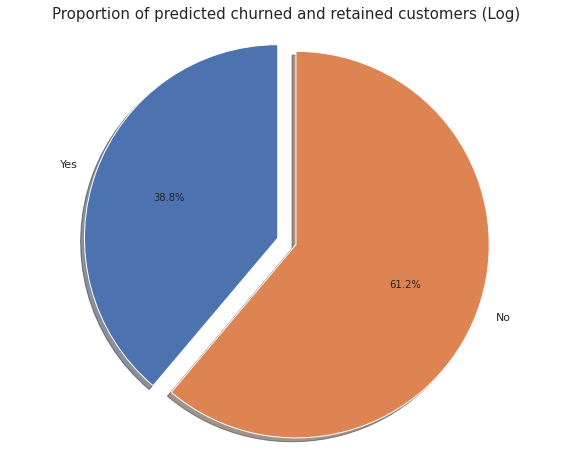

In [80]:
# Log reg
Prediction = log.predict(X_test)
Id = list(range(len(Prediction)))
submission = pd.DataFrame({
    "Id":Id,
    "Prediction":Prediction
})
print(submission.head())

# Proportion of churning customers
labels = 'Yes', 'No'
sizes = [submission.Prediction[submission['Prediction']==1].count(), submission.Prediction[submission['Prediction']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of predicted churned and retained customers (Log)", size = 15)
plt.show()

   Id  Prediction
0   0           1
1   1           1
2   2           0
3   3           0
4   4           0


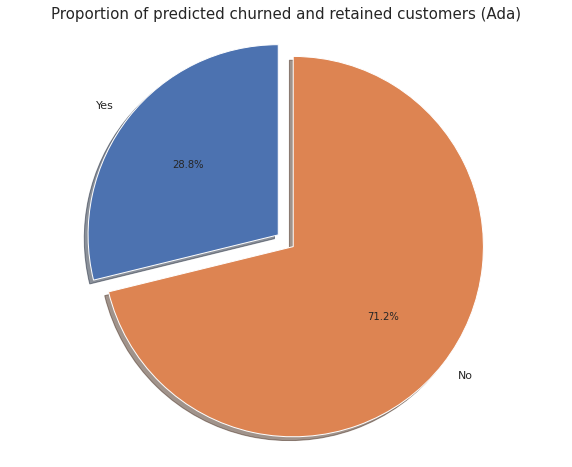

In [81]:
# Ada
Prediction = Ada.predict(X_test)
Id = list(range(len(Prediction)))
submission = pd.DataFrame({
    "Id":Id,
    "Prediction":Prediction
})
print(submission.head())

# Proportion of churning customers
labels = 'Yes', 'No'
sizes = [submission.Prediction[submission['Prediction']==1].count(), submission.Prediction[submission['Prediction']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of predicted churned and retained customers (Ada)", size = 15)
plt.show()

According to AUC of validation data, **_Random Forest_** is the best  model.

In [82]:
# Model RF
Prediction = RF.predict(X_test)
Id = list(range(len(Prediction)))
submission = pd.DataFrame({
    "Id":Id,
    "Prediction":Prediction
})

submission.to_csv("Vallian_Sayoga-submission.csv", index=False)

In churning prediction, False Positive rate is more desirable than False Negative since it can help BRI to anticipate churning customers